In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#Data 2018
energy_2018 = pd.read_csv("load 2018.csv").iloc[:,2].rename('energy 2018') #only 2018 actual energy
y_energy_2018 = energy_2018.fillna(energy_2018.mean()) #used for model energy

#Data 2019
wea_data_2019=pd.read_csv("weather_helsinki_2019.csv")
weather_2019=wea_data_2019.T.iloc[5:].T.iloc[0:8760]
energy_2019_true = pd.read_csv("load 2019.csv").iloc[:,2].rename('energy 2019') #only actual energy 2019
energy_2019_true = energy_2019_true.fillna(energy_2019_true.mean()) #used for model fillna with mean value
X_weather_2019= weather_2019.fillna(weather_2019.mean()) #used to predict year 2019

#Data 2020 for prediction
wea_data20=pd.read_csv("weather_helsinki_2020.csv")
weather20=wea_data20.T.iloc[5:].T
weather20 = weather20.fillna(weather20.mean())
load20=pd.read_csv("load 2020.csv")
load20=load20.iloc[:8760,2]
load20=load20.str.replace('-','') #Replacing '-' in data with empty value
load20=pd.to_numeric(load20,errors='coerce') #converting object to integer
load20=load20.fillna(load20.mean()).rename('energy 2020') #fillna values with mean


In [2]:
#Creating time features by using pandas
#2019 time
time=pd.DataFrame()
time['date']=pd.date_range(start='1/1/2019',end='1/1/2020',freq='H')
time['year'] = time['date'].dt.year 
time['month'] = time['date'].dt.month 
time['day'] = time['date'].dt.day
time['hour'] = time['date'].dt.hour 
time['weekday']=time['date'].dt.day_name()
tdate=time.iloc[:,2:] #removing years and date
time

,date,year,month,day,hour,weekday
0,2019-01-01 00:00:00,2019,1,1,0,Tuesday
1,2019-01-01 01:00:00,2019,1,1,1,Tuesday
2,2019-01-01 02:00:00,2019,1,1,2,Tuesday
3,2019-01-01 03:00:00,2019,1,1,3,Tuesday
4,2019-01-01 04:00:00,2019,1,1,4,Tuesday
...,...,...,...,...,...,...
8756,2019-12-31 20:00:00,2019,12,31,20,Tuesday
8757,2019-12-31 21:00:00,2019,12,31,21,Tuesday
8758,2019-12-31 22:00:00,2019,12,31,22,Tuesday
8759,2019-12-31 23:00:00,2019,12,31,23,Tuesday


In [3]:
#Calculating hourly energy average and daily energy average of all yearly values of 2018 and using them as a feature
from array import *

def week(i):
        switcher={
                0:'Monday',
                1:'Tuesday',
                2:'Wednesday',
                3:'Thursday',
                4:'Friday',
                5:'Saturday',
                6:'Sunday',
             }
        return switcher.get(i,"Invalid day of week")


load_2018=pd.read_csv("load 2018.csv").iloc[:,2] #only 2018
#print(load_2018.head())
dates_2018 = pd.DataFrame(pd.read_csv("load 2018.csv"))
load_weekday = {}
for i in range (7):
    load_weekday[i] = pd.DataFrame()
load_monday = pd.DataFrame()
load_tuesday = pd.DataFrame()
load_wednesday = pd.DataFrame()
load_thursday = pd.DataFrame()
load_friday = pd.DataFrame()
load_saturday = pd.DataFrame()
load_sunday = pd.DataFrame()
#print(load_monday)
load_hours = {}
for i in range (24):
    load_hours[i] = pd.DataFrame()

#print(dates_2018.head())
for i_date, row in dates_2018.iterrows():
    splitDay = row['Time (UTC)'].split('-')
    day = pd.Timestamp(splitDay[0])
    #print(day.hour)
    
    index_hour =  0 if load_hours[day.hour].empty else  load_hours[day.hour].index.max()+1

    load_hours[day.hour].loc[index_hour, 'load'] = row['Actual Total Load [MW] - BZN|FI']
    dates_2018.loc[i_date,'Day of week number'] = day.dayofweek
    dates_2018.loc[i_date,'Day of week'] = week(day.dayofweek)

    index_weekday = 0 if load_weekday[day.dayofweek].empty  else load_weekday[day.dayofweek].index.max()+1
    load_weekday[day.dayofweek].loc[index_weekday, 'load'] = row['Actual Total Load [MW] - BZN|FI']


print("monday mean : " + str(load_weekday[0].load.mean()))
print("tuesday mean : " + str(load_weekday[1].load.mean()))
print("wednesday mean : " + str(load_weekday[2].load.mean()))
print("thursday mean : " + str(load_weekday[3].load.mean()))
print("friday mean : " + str(load_weekday[4].load.mean()))
print("saturday mean : " + str(load_weekday[5].load.mean()))
print("sunday mean : " + str(load_weekday[6].load.mean()))

print("-----------------------------------")
print("times in UTC")
hourss={}
for i in range(24):
    hourss[i]=load_hours[i].load.mean()
    print(str(i) + " UTC hour avg:  " + str(load_hours[i].load.mean()))

monday mean : 9973.842767295597
tuesday mean : 9891.201923076924
wednesday mean : 9947.390361445783
thursday mean : 9861.626602564103
friday mean : 9837.25
saturday mean : 9616.49358974359
sunday mean : 9418.008814102564
-----------------------------------
times in UTC
0 UTC hour avg:  8791.019178082192
1 UTC hour avg:  8773.934246575342
2 UTC hour avg:  8895.961643835617
3 UTC hour avg:  9308.227397260274
4 UTC hour avg:  9783.16712328767
5 UTC hour avg:  10036.413698630136
6 UTC hour avg:  10183.936813186812
7 UTC hour avg:  10206.534246575342
8 UTC hour avg:  10214.676712328766
9 UTC hour avg:  10199.772602739726
10 UTC hour avg:  10141.192307692309
11 UTC hour avg:  10072.804945054944
12 UTC hour avg:  10036.553424657533
13 UTC hour avg:  10058.016438356164
14 UTC hour avg:  10127.128767123288
15 UTC hour avg:  10203.87397260274
16 UTC hour avg:  10308.383561643835
17 UTC hour avg:  10316.545205479451
18 UTC hour avg:  10062.52602739726
19 UTC hour avg:  9909.635616438356
20 UTC ho

In [4]:
#mapping above average values on weekdays and hours and concatenating all the features for training model
monday=load_weekday[0].load.mean()
tuesday=load_weekday[1].load.mean()
wednesday=load_weekday[2].load.mean()
thursday=load_weekday[3].load.mean()
friday=load_weekday[4].load.mean()
saturday=load_weekday[5].load.mean()
sunday=load_weekday[6].load.mean()

#mapping mean values
feature=pd.concat([X_weather_2019,
                   energy_2018,
                   tdate],axis=1)

#mapping daily average of year 2018
feature['weekday'] = feature['weekday'].map({'Monday':monday,'Tuesday': tuesday,'Wednesday':wednesday,
                                             'Thursday':thursday,'Friday':friday, 
                                             'Saturday': saturday,'Sunday':sunday})
#mapping hourly average of year 2018
feature['hour'] = feature['hour'].map({0: hourss[0],1: hourss[0],2: hourss[0],
                                       3:hourss[3],4:hourss[4], 
                                       5:hourss[5],6:hourss[6],
                                       7:hourss[7],8:hourss[8],
                                       9:hourss[9],10:hourss[10],
                                       11:hourss[11],12:hourss[12],
                                       13:hourss[13],14:hourss[14],
                                       15:hourss[15],16:hourss[16],
                                       17:hourss[17],18:hourss[18],
                                       19:hourss[19],20:hourss[20],
                                       21:hourss[21],22:hourss[22],
                                       23:hourss[23]})
feature2019=feature[0:8760].fillna(feature.mean())
feature2019=feature2019.rename(columns={'hour': 'Mean of hours energy (2018)','weekday':'Mean of days energy (2018)'})
#feature2019.index=time.iloc[:8760,0] #Assigning date & time as index
#energy_2019_true.index=time.iloc[:8760,0] #Assigning date & time as index
feature2019

,Cloud amount (1/8),Pressure (msl) (hPa),Relative humidity (%),Precipitation intensity (mm/h),Snow depth (cm),Air temperature (degC),Dew-point temperature (degC),Horizontal visibility (m),Wind direction (deg),Gust speed (m/s),Wind speed (m/s),energy 2018,month,day,Mean of hours energy (2018),Mean of days energy (2018)
0,8.0,1000.4,100.0,1.3,11.0,0.3,0.3,2240.0,230.0,10.0,4.7,9410.0,1,1,8791.019178,9891.201923
1,8.0,998.2,100.0,0.1,12.0,1.0,1.0,2690.0,237.0,7.2,4.2,9242.0,1,1,8791.019178,9891.201923
2,8.0,996.2,100.0,0.7,11.0,1.5,1.5,2340.0,256.0,6.9,4.0,9260.0,1,1,8791.019178,9891.201923
3,8.0,993.9,100.0,0.0,11.0,1.9,1.9,2510.0,265.0,6.4,3.4,9364.0,1,1,9308.227397,9891.201923
4,8.0,991.4,100.0,0.5,10.0,2.1,2.1,3310.0,239.0,9.5,4.3,9586.0,1,1,9783.167123,9891.201923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,1011.0,78.0,0.0,0.0,-2.3,-5.7,50000.0,292.0,6.1,4.9,11010.0,12,31,9909.635616,9891.201923
8756,0.0,1011.2,84.0,0.0,0.0,-2.5,-4.8,50000.0,282.0,6.7,4.2,11402.0,12,31,9851.287671,9891.201923
8757,0.0,1011.4,90.0,0.0,0.0,-2.3,-3.7,50000.0,263.0,5.9,4.8,11291.0,12,31,9503.600000,9891.201923
8758,0.0,1011.6,95.0,0.0,0.0,-1.7,-2.4,50000.0,273.0,6.9,5.1,10816.0,12,31,9136.367123,9891.201923


 0 Cloud amount (1/8)= 0.00
 1 Pressure (msl) (hPa)= 0.00
 2 Relative humidity (%)= 0.01
 3 Precipitation intensity (mm/h)= 0.00
 4 Snow depth (cm)= 0.25
 5 Air temperature (degC)= 0.21
 6 Dew-point temperature (degC)= 0.04
 7 Horizontal visibility (m)= 0.01
 8 Wind direction (deg)= 0.00
 9 Gust speed (m/s)= 0.00
10 Wind speed (m/s)= 0.00
11 energy 2018= 0.16
12    month= 0.20
13      day= 0.01
14 Mean of hours energy (2018)= 0.08
15 Mean of days energy (2018)= 0.02


C:\Users\TALAL.Talal.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

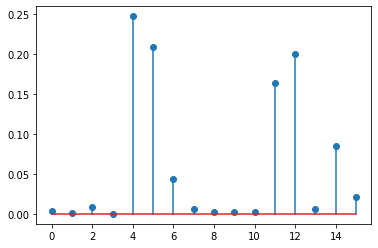

In [5]:
#Calculating feature importance
X_train,X_test,y_train,y_test=train_test_split(feature2019,energy_2019_true,train_size=0.75)

gbr = GradientBoostingRegressor(max_features=3,random_state=0)
gbr.fit(X_train, y_train)
for i in range(len(feature2019.columns)):
    print("%2d %8s=%5.2f" % (i,feature2019.columns[i], gbr.feature_importances_[i]))
plt.stem(gbr.feature_importances_)

In [6]:
#Removing uncessary columns
cols = [0,1,2,3,7,8,9,10,13]
feature2019=feature2019.drop(feature2019.columns[cols],axis=1)
feature2019

,Snow depth (cm),Air temperature (degC),Dew-point temperature (degC),energy 2018,month,Mean of hours energy (2018),Mean of days energy (2018)
0,11.0,0.3,0.3,9410.0,1,8791.019178,9891.201923
1,12.0,1.0,1.0,9242.0,1,8791.019178,9891.201923
2,11.0,1.5,1.5,9260.0,1,8791.019178,9891.201923
3,11.0,1.9,1.9,9364.0,1,9308.227397,9891.201923
4,10.0,2.1,2.1,9586.0,1,9783.167123,9891.201923
...,...,...,...,...,...,...,...
8755,0.0,-2.3,-5.7,11010.0,12,9909.635616,9891.201923
8756,0.0,-2.5,-4.8,11402.0,12,9851.287671,9891.201923
8757,0.0,-2.3,-3.7,11291.0,12,9503.600000,9891.201923
8758,0.0,-1.7,-2.4,10816.0,12,9136.367123,9891.201923


CV score.......... 0.9585611653955075
Training score.... 0.963841349982576
Test score........ 0.9631287473983985


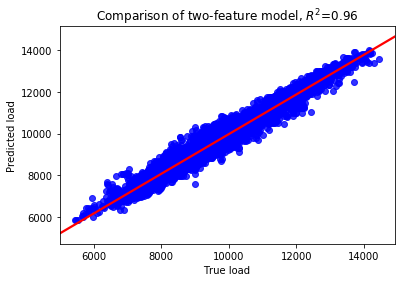

In [7]:
#Using different regressor to check accuracy
#Gradient boosting regressor
from sklearn.metrics import r2_score
X_train,X_test,y_train,y_test=train_test_split(feature2019,energy_2019_true,train_size=0.75)
gbr = GradientBoostingRegressor(max_depth=3,random_state=0)
gbr.fit(X_train, y_train)
yhat=gbr.predict(X_train)

RsquaredCV=cross_val_score(gbr, X_train, y_train, cv=5).mean()
RsquaredTR=gbr.score(X_train,y_train)

sns.regplot(x=y_train,y=yhat, line_kws={"color": "red"},scatter_kws={"color": "blue"})
yhat=gbr.predict(X_test)
plt.xlabel('True load')
plt.ylabel('Predicted load')
plt.title('Comparison of two-feature model, $R^2$=%3.2f' % RsquaredCV)
print("CV score..........", RsquaredCV)
print("Training score....", RsquaredTR)
print("Test score........",r2_score(y_true=y_test,y_pred=yhat))


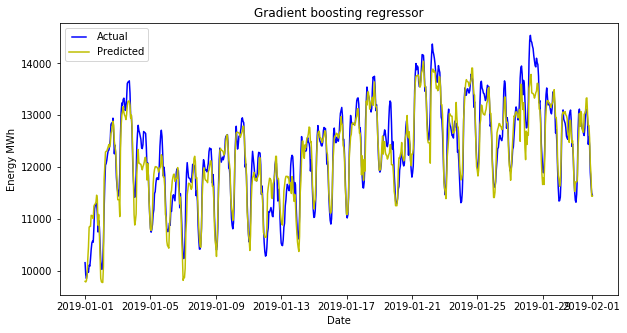

In [8]:
#Plotting predicted value
from matplotlib.legend_handler import HandlerLine2D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
y_pre=gbr.predict(feature2019.iloc[0:746,:])
ytrue=energy_2019_true[0:746]
y_pre=pd.DataFrame(y_pre,columns=['Predicted Energy'])
ytrue.index=time.iloc[:746,0]
y_pre.index=ytrue.index
plt.figure(figsize=(10,5))
line1,=plt.plot(ytrue,'b',label='Actual')
line2,=plt.plot(y_pre,'y',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Energy MWh')
plt.title('Gradient boosting regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()


CV score.......... 0.9063675297081712
Training score.... 0.9067367754935374
Test score........ 0.9107188064354136


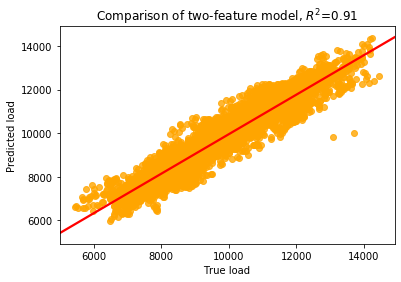

In [9]:
# Ordinary Linear Regression First
lr=LinearRegression()
lr.fit(X_train,y_train)
yhat=lr.predict(X_train)

# Cross_val_score and score are coefficient of determinations, R^2
RsquaredCV=cross_val_score(lr, X_train, y_train, cv=5).mean()
RsquaredTR=lr.score(X_train,y_train)

sns.regplot(x=y_train,y=yhat, line_kws={"color": "red"},scatter_kws={"color": "orange"})
yhat=lr.predict(X_test)
plt.xlabel('True load')
plt.ylabel('Predicted load')
plt.title('Comparison of two-feature model, $R^2$=%3.2f' % RsquaredCV)
print("CV score..........", RsquaredCV)
print("Training score....", RsquaredTR)
print("Test score........",r2_score(y_true=y_test,y_pred=yhat))

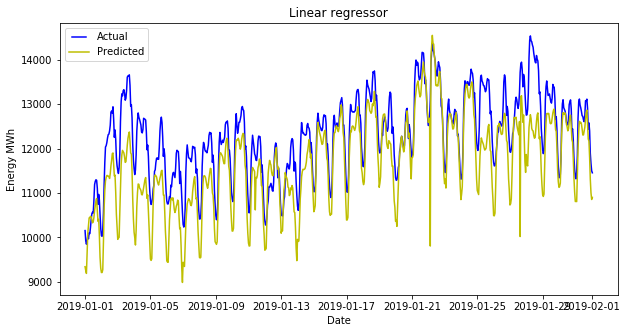

In [10]:
#Plotting 
y_pre=lr.predict(feature2019.iloc[0:746,:])
ytrue=energy_2019_true[0:746]
y_pre=pd.DataFrame(y_pre,columns=['Predicted Energy'])
ytrue.index=time.iloc[:746,0]
y_pre.index=ytrue.index
plt.figure(figsize=(10,5))
line1,=plt.plot(ytrue,'b',label='Actual')
line2,=plt.plot(y_pre,'y',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Energy MWh')
plt.title('Linear regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

CV score.......... 0.8948413240618598
Training score.... 0.8970870776243501
Test score........ 0.9045961789728527


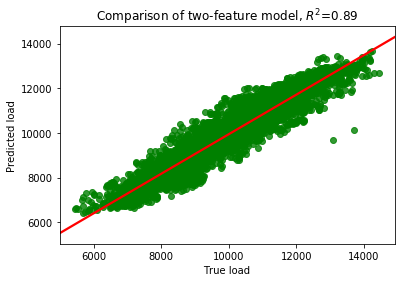

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn import datasets
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import cross_val_score

mlp = MLPRegressor(hidden_layer_sizes=(24,7,15),activation='relu',
                    solver='lbfgs',max_iter=1000,random_state=0)
mlp.fit(X=X_train, y=y_train)
yhat=mlp.predict(X_train)

RsquaredCV=cross_val_score(mlp, X_train, y_train, cv=5).mean()
RsquaredTR=mlp.score(X_train,y_train)

sns.regplot(x=y_train,y=yhat, line_kws={"color": "red"},scatter_kws={"color": "green"})
yhat=mlp.predict(X_test)
plt.xlabel('True load')
plt.ylabel('Predicted load')
plt.title('Comparison of two-feature model, $R^2$=%3.2f' % RsquaredCV)
print("CV score..........", RsquaredCV)
print("Training score....", RsquaredTR)
print("Test score........",r2_score(y_true=y_test,y_pred=yhat))

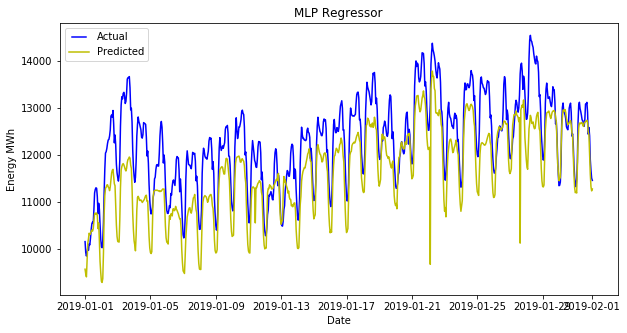

In [12]:
y_pre=mlp.predict(feature2019.iloc[0:746,:])
ytrue=energy_2019_true[0:746]
y_pre=pd.DataFrame(y_pre,columns=['Predicted Energy'])
ytrue.index=time.iloc[:746,0]
y_pre.index=ytrue.index
plt.figure(figsize=(10,5))
line1,=plt.plot(ytrue,'b',label='Actual')
line2,=plt.plot(y_pre,'y',label='Predicted')
plt.xlabel('Date')
plt.ylabel('Energy MWh')
plt.title('MLP Regressor')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()


In [13]:
#Predicting year 2020
#Creating time feature from pandas
time20=pd.DataFrame()
time20['date']=pd.date_range(start='1/1/2020',end='1/1/2021',freq='H')
time20['year'] = time20['date'].dt.year 
time20['month'] = time20['date'].dt.month 
time20['day'] = time20['date'].dt.day 
time20['hour'] = time20['date'].dt.hour 
time20['weekday']=time20['date'].dt.day_name()
tdate2=time20.iloc[:,2:]
tdate2

,month,day,hour,weekday
0,1,1,0,Wednesday
1,1,1,1,Wednesday
2,1,1,2,Wednesday
3,1,1,3,Wednesday
4,1,1,4,Wednesday
...,...,...,...,...
8780,12,31,20,Thursday
8781,12,31,21,Thursday
8782,12,31,22,Thursday
8783,12,31,23,Thursday


In [14]:
#Calculating hourly energy average and daily energy average of all yearly values of 2019 and using them as a feature
from array import *

def week(i):
        switcher={
                0:'Monday',
                1:'Tuesday',
                2:'Wednesday',
                3:'Thursday',
                4:'Friday',
                5:'Saturday',
                6:'Sunday',
             }
        return switcher.get(i,"Invalid day of week")


load_2019=pd.read_csv("load 2019.csv").iloc[:,2] #only 2019 actual
#print(load_2019.head())
dates_2019 = pd.DataFrame(pd.read_csv("load 2019.csv"))
load_weekday = {}
for i in range (7):
    load_weekday[i] = pd.DataFrame()
load_monday = pd.DataFrame()
load_tuesday = pd.DataFrame()
load_wednesday = pd.DataFrame()
load_thursday = pd.DataFrame()
load_friday = pd.DataFrame()
load_saturday = pd.DataFrame()
load_sunday = pd.DataFrame()
#print(load_monday)
load_hours = {}
for i in range (24):
    load_hours[i] = pd.DataFrame()

#print(dates_2019.head())
for i_date, row in dates_2019.iterrows():
    splitDay = row['Time (UTC)'].split('-')
    day = pd.Timestamp(splitDay[0])
    #print(day.hour)
    
    index_hour =  0 if load_hours[day.hour].empty else  load_hours[day.hour].index.max()+1

    load_hours[day.hour].loc[index_hour, 'load'] = row['Actual Total Load [MW] - BZN|FI']
    dates_2019.loc[i_date,'Day of week number'] = day.dayofweek
    dates_2019.loc[i_date,'Day of week'] = week(day.dayofweek)

    index_weekday = 0 if load_weekday[day.dayofweek].empty  else load_weekday[day.dayofweek].index.max()+1
    load_weekday[day.dayofweek].loc[index_weekday, 'load'] = row['Actual Total Load [MW] - BZN|FI']


print("monday mean : " + str(load_weekday[0].load.mean()))
print("tuesday mean : " + str(load_weekday[1].load.mean()))
print("wednesday mean : " + str(load_weekday[2].load.mean()))
print("thursday mean : " + str(load_weekday[3].load.mean()))
print("friday mean : " + str(load_weekday[4].load.mean()))
print("saturday mean : " + str(load_weekday[5].load.mean()))
print("sunday mean : " + str(load_weekday[6].load.mean()))

print("-----------------------------------")
print("times in UTC")
hourss={}
for i in range(24):
    hourss[i]=load_hours[i].load.mean() #Hourly average of year 2019
    print(str(i) + " UTC hour avg:  " + str(load_hours[i].load.mean()))

monday mean : 9597.722756410256
tuesday mean : 9665.555817610062
wednesday mean : 9657.589743589744
thursday mean : 9637.38701923077
friday mean : 9589.83173076923
saturday mean : 9277.88060897436
sunday mean : 9246.330128205129
-----------------------------------
times in UTC
0 UTC hour avg:  8549.750684931507
1 UTC hour avg:  8530.742465753425
2 UTC hour avg:  8653.16712328767
3 UTC hour avg:  9050.882191780822
4 UTC hour avg:  9508.27397260274
5 UTC hour avg:  9742.90410958904
6 UTC hour avg:  9882.397260273972
7 UTC hour avg:  9913.660273972602
8 UTC hour avg:  9924.038356164383
9 UTC hour avg:  9916.841095890411
10 UTC hour avg:  9859.230136986302
11 UTC hour avg:  9788.871232876712
12 UTC hour avg:  9757.964383561644
13 UTC hour avg:  9785.082191780823
14 UTC hour avg:  9869.476712328767
15 UTC hour avg:  9952.123287671233
16 UTC hour avg:  10046.216438356165
17 UTC hour avg:  10043.753424657534
18 UTC hour avg:  9797.295890410958
19 UTC hour avg:  9641.04109589041
20 UTC hour av

In [15]:
#weekly average of year 2019
monday=load_weekday[0].load.mean()
tuesday=load_weekday[1].load.mean()
wednesday=load_weekday[2].load.mean()
thursday=load_weekday[3].load.mean()
friday=load_weekday[4].load.mean()
saturday=load_weekday[5].load.mean()
sunday=load_weekday[6].load.mean()


#Using only most important features
feature2020=pd.concat([weather20.iloc[:,4],weather20.iloc[:,5],weather20.iloc[:,6],
                       energy_2019_true,
                       tdate2.iloc[:,0],tdate2.iloc[:,2:]],axis=1)
#mapping weekday average of year 2019
feature2020['weekday'] = feature2020['weekday'].map({'Monday':monday,'Tuesday': tuesday,'Wednesday':wednesday,
                                             'Thursday':thursday,'Friday':friday, 
                                             'Saturday': saturday,'Sunday':sunday})
#mapping hourly average of year 2019
feature2020['hour'] = feature2020['hour'].map({0: hourss[0],1: hourss[0],2: hourss[0],
                                               3:hourss[3],4:hourss[4], 
                                               5:hourss[5],6:hourss[6],
                                               7:hourss[7],8:hourss[8],
                                               9:hourss[9],10:hourss[10],
                                               11:hourss[11],12:hourss[12],
                                               13:hourss[13],14:hourss[14],
                                               15:hourss[15],16:hourss[16],
                                               17:hourss[17],18:hourss[18],
                                               19:hourss[19],20:hourss[20],
                                               21:hourss[21],22:hourss[22],
                                               23:hourss[23]})
feature2020=feature2020.dropna()
feature2020=feature2020.rename(columns={'hour': 'Mean of hours energy (2019)','weekday':'Mean of days energy (2019)'})
feature2020.index=time20.iloc[:7897,0]
load20.index=time20.iloc[:8760,0]
feature2020

,Snow depth (cm),Air temperature (degC),Dew-point temperature (degC),energy 2019,month,Mean of hours energy (2019),Mean of days energy (2019)
date,,,,,,,
2020-01-01 00:00:00,0.0,-1.2,-1.5,10152.0,1,8549.750685,9657.589744
2020-01-01 01:00:00,0.0,-0.7,-1.4,9920.0,1,8549.750685,9657.589744
2020-01-01 02:00:00,0.0,-0.5,-1.4,9845.0,1,8549.750685,9657.589744
2020-01-01 03:00:00,0.0,0.1,-1.4,9913.0,1,9050.882192,9657.589744
2020-01-01 04:00:00,0.0,-0.3,-1.5,10027.0,1,9508.273973,9657.589744
...,...,...,...,...,...,...,...
2020-11-24 20:00:00,0.0,-2.3,-2.7,10608.0,11,9589.367123,9665.555818
2020-11-24 21:00:00,0.0,-1.8,-2.2,10322.0,11,9247.635616,9665.555818
2020-11-24 22:00:00,0.0,-1.1,-1.6,9766.0,11,8884.221918,9665.555818


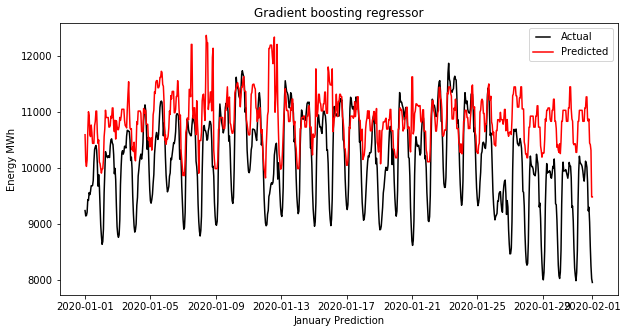

In [16]:
#Predicting january energy data of year 2020
#By Gradient boosting regressor
y_pre=gbr.predict(feature2020.iloc[0:746,:])
ytrue=load20[0:746]
y_pre=pd.DataFrame(y_pre,columns=['Predicted Energy'])
y_pre.index=ytrue.index
plt.figure(figsize=(10,5))
line1,=plt.plot(ytrue,'black',label='Actual')
line2,=plt.plot(y_pre,'r',label='Predicted')
plt.title("Gradient boosting regressor")
plt.xlabel('January Prediction')
plt.ylabel('Energy MWh')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

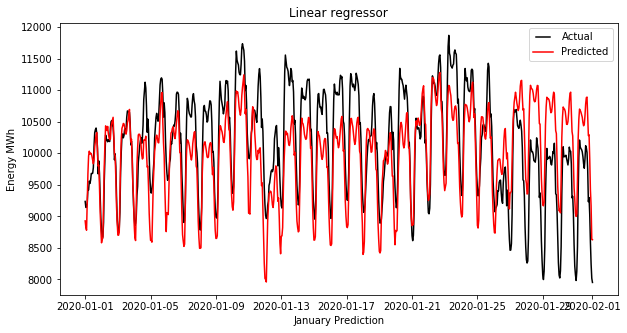

In [17]:
#Predicting january energy data of year 2020
#By linear regressor
y_pre=lr.predict(feature2020.iloc[0:746,:])
ytrue=load20[0:746]
y_pre=pd.DataFrame(y_pre,columns=['Predicted Energy'])
y_pre.index=ytrue.index
plt.figure(figsize=(10,5))
line1,=plt.plot(ytrue,'black',label='Actual')
line2,=plt.plot(y_pre,'r',label='Predicted')
plt.title("Linear regressor")
plt.xlabel('January Prediction')
plt.ylabel('Energy MWh')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

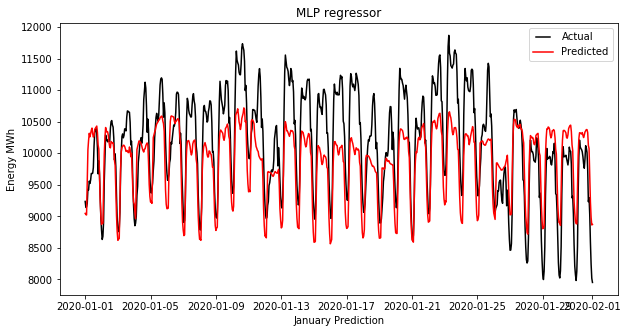

In [18]:
#Predicting january energy data of year 2020
#By MLPR
y_pre=mlp.predict(feature2020.iloc[0:746,:])
ytrue=load20[0:746]
y_pre=pd.DataFrame(y_pre,columns=['Predicted Energy'])
y_pre.index=ytrue.index
plt.figure(figsize=(10,5))
line1,=plt.plot(ytrue,'black',label='Actual')
line2,=plt.plot(y_pre,'r',label='Predicted')
plt.title("MLP regressor")
plt.xlabel('January Prediction')
plt.ylabel('Energy MWh')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()